In [1]:
import pyspark
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext



In [2]:
os.chdir('../Project/finding-elo/')
sc = pyspark.SparkContext()
spark = SparkSession(sc)
sqlContext = SQLContext(sc)

In [3]:
games = sc.textFile('data_uci.pgn')
games = games.map(lambda l:l.rstrip())

In [4]:
def myfunc(a):
    if "1/2" in a:
        return 0
    if "1-0" in a:
        return 1
    else:
        return -1

def eval_moves(moves):
    score = 0
    for i in range(len(moves)-1):
        score = score + moves[i+1] - moves[i]
    return score
        

In [5]:
result = games.filter(lambda l:"Result" in l).map(lambda l: myfunc(l)).zipWithIndex().filter(lambda vi: vi[1] < 25000).map(lambda l:(l[1],l[0]))
whiteelo = games.filter(lambda l: "WhiteElo" in l).map(lambda l:int(l.split()[1][1:5])).zipWithIndex().map(lambda l:(l[1],l[0]))
blackelo = games.filter(lambda l: "BlackElo" in l).map(lambda l:int(l.split()[1][1:5])).zipWithIndex().map(lambda l:(l[1],l[0]))
stockfish = sc.textFile('stockfish.csv').filter(lambda l: 'Event' not in l).map(lambda l:[0]+[int(x) for x in l.split(',')[1].split(" ") if x!=''])\
.map(lambda l: eval_moves(l)).zipWithIndex().filter(lambda vi: vi[1] < 25000).map(lambda l:(l[1],l[0]))


In [6]:
temp = whiteelo.join(blackelo).join(result).join(stockfish).map(lambda l:[l[1][0][0][0],l[1][0][0][1],l[1][0][0][0]-l[1][0][0][1],l[1][0][1],l[1][1]])
df = temp.toDF(['white_rating','black_rating','rating_diff','result','score'])


In [7]:
vectorAssembler = VectorAssembler(inputCols = ['result','score'], outputCol = "features")
df = vectorAssembler.transform(df)
white_df = df.select(['features', 'white_rating'])
black_df = df.select(['features','black_rating'])


splits = white_df.randomSplit([0.8, 0.2])
train_df = splits[0]
test_df = splits[1]

lr = LinearRegression(featuresCol = 'features', labelCol='white_rating', maxIter=10)
lr_model_white = lr.fit(train_df)
lr_predictions = lr_model_white.transform(test_df)
lr_predictions.select("prediction","white_rating","features").show(15)


+-----------------+------------+---------+
|       prediction|white_rating| features|
+-----------------+------------+---------+
|2239.763291581192|        1394|(2,[],[])|
|2239.763291581192|        1546|(2,[],[])|
|2239.763291581192|        1717|(2,[],[])|
|2239.763291581192|        1768|(2,[],[])|
|2239.763291581192|        1903|(2,[],[])|
|2239.763291581192|        1932|(2,[],[])|
|2239.763291581192|        1939|(2,[],[])|
|2239.763291581192|        1939|(2,[],[])|
|2239.763291581192|        1942|(2,[],[])|
|2239.763291581192|        2011|(2,[],[])|
|2239.763291581192|        2069|(2,[],[])|
|2239.763291581192|        2087|(2,[],[])|
|2239.763291581192|        2096|(2,[],[])|
|2239.763291581192|        2109|(2,[],[])|
|2239.763291581192|        2133|(2,[],[])|
+-----------------+------------+---------+
only showing top 15 rows



In [8]:
test_result = lr_model_white.evaluate(test_df)
print("Mean Absolute Error on test data = %g" % test_result.meanAbsoluteError)

Mean Absolute Error on test data = 206.444


In [9]:
print("Coefficients: %s" % str(lr_model_white.coefficients))
print("Intercept: %s" % str(lr_model_white.intercept))


Coefficients: [84.46814761616123,-0.003658773871032573]
Intercept: 2239.76329158


(1000, 3000)

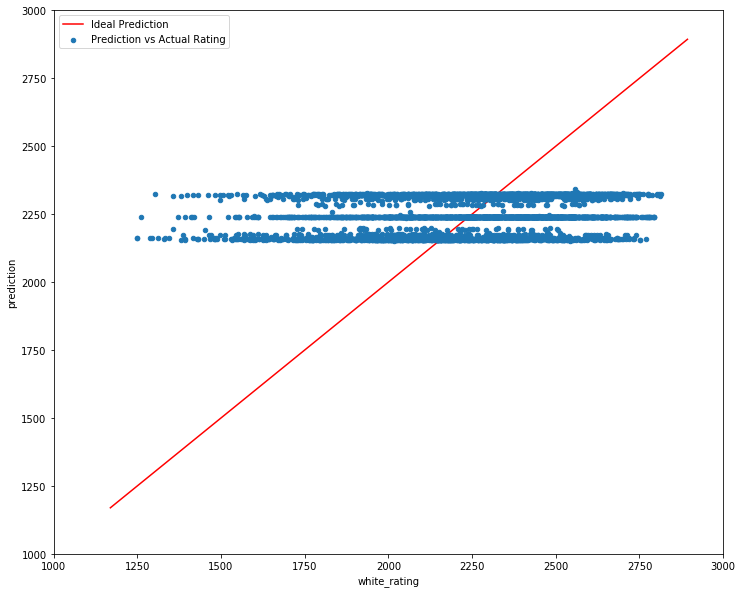

In [10]:
x=lr_predictions.toPandas()
ax=x.plot.scatter(x='white_rating',y='prediction',figsize=(12,10),label='Prediction vs Actual Rating')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
# now plot both limits against eachother
ax.plot(lims, lims,'r' ,zorder=0,label='Ideal Prediction')
ax.legend()
ax.set_xlim([1000,3000])
ax.set_ylim([1000,3000])






In [11]:
splits = black_df.randomSplit([0.8, 0.2])
train_df = splits[0]
test_df = splits[1]
lr = LinearRegression(featuresCol = 'features', labelCol='black_rating', maxIter=10)
lr_model_black = lr.fit(train_df)
lr_predictions = lr_model_black.transform(test_df)
lr_predictions.select("prediction","black_rating","features").show(5)

+------------------+------------+---------+
|        prediction|black_rating| features|
+------------------+------------+---------+
|2247.7115347059184|        1779|(2,[],[])|
|2247.7115347059184|        1880|(2,[],[])|
|2247.7115347059184|        1902|(2,[],[])|
|2247.7115347059184|        1953|(2,[],[])|
|2247.7115347059184|        1997|(2,[],[])|
+------------------+------------+---------+
only showing top 5 rows



In [12]:
test_result = lr_model_black.evaluate(test_df)
print("Mean Absolute Error on test data = %g" % test_result.meanAbsoluteError)

Mean Absolute Error on test data = 206.891


In [13]:
print("Coefficients: %s" % str(lr_model_black.coefficients))
print("Intercept: %s" % str(lr_model_black.intercept))



Coefficients: [-78.56312836361114,0.0015834224577899857]
Intercept: 2247.71153471


(1000, 3000)

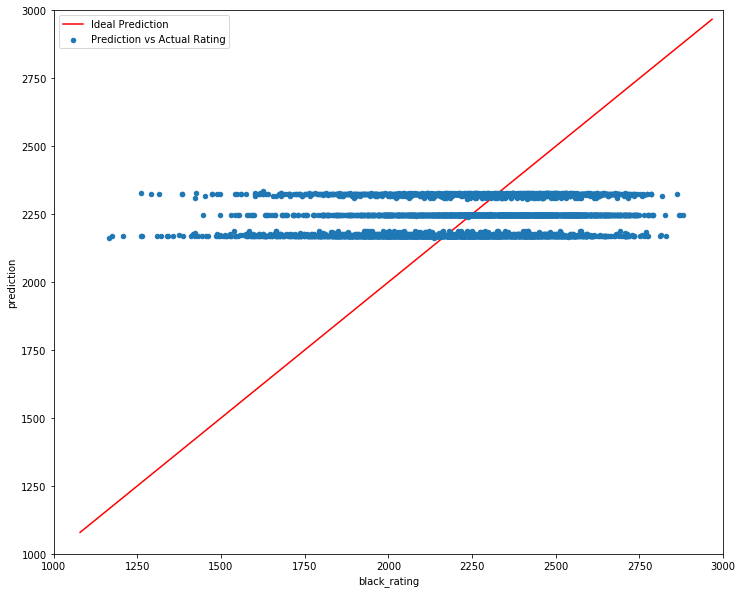

In [14]:
x=lr_predictions.toPandas()
ax=x.plot.scatter(x='black_rating',y='prediction',figsize=(12,10),label='Prediction vs Actual Rating')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
# now plot both limits against eachother
ax.plot(lims, lims,'r' ,zorder=0,label='Ideal Prediction')
ax.legend()
ax.set_xlim([1000,3000])
ax.set_ylim([1000,3000])





In [15]:
games = sc.textFile('data_uci.pgn')
games = games.map(lambda l:l.rstrip())

In [16]:
result = games.filter(lambda l:"Result" in l).map(lambda l: myfunc(l)).zipWithIndex().filter(lambda vi: vi[1] >= 25000).map(lambda l:(l[1],l[0]))
stockfish = sc.textFile('stockfish.csv').filter(lambda l: 'Event' not in l).map(lambda l:[0]+[int(x) for x in l.split(',')[1].split(" ") if x!=''])\
.map(lambda l: eval_moves(l)).zipWithIndex().filter(lambda vi: vi[1] >= 25000).map(lambda l:(l[1],l[0]))

In [17]:
test_set = result.join(stockfish).map(lambda l:[l[0]+1,l[1][0],l[1][1]]).toDF(['Event','result','score'])
vectorAssembler = VectorAssembler(inputCols = ['result','score'], outputCol = "features")
test_set = vectorAssembler.transform(test_set)
test_set_white = lr_model_white.transform(test_set)
test_set_black = lr_model_black.transform(test_set)

black = test_set_black.select('Event','prediction').toPandas()
black.columns=['Event','BlackElo']

white = test_set_white.select('Event','prediction').toPandas()
white.columns = ['Event','WhiteElo']



In [18]:

white['BlackElo'] = black.BlackElo
white.sort_values(by='Event').set_index('Event').to_csv('LR.csv')